<a href="https://colab.research.google.com/github/pawljmlo/covid-ur-wasting/blob/main/wasting-anaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [396]:
import pandas as pd
import numpy as np

import math

In [397]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## import data

In [398]:
path_overlapping = "/content/drive/MyDrive/projekty/review-ai-covid-ur/data/covid-data-extracted-overlapping-edited.csv"

In [399]:
df = pd.read_csv(path_overlapping)

In [400]:
df.head()

,Unnamed: 0,Reference ID,ID in the review,Primary study Bibtex ID,Num,Per one,New,Reference,Medium,What,Link,Was ver. reported?,Date reported,Versions,Ver. Used,Month,Day,Published?,Pub-link,Journal,Conference,Other,Av-Month,Av-Day,Av-Year,Retracted,How many datasets were used?,Total CTs,C-19 CTs,Total X-Rays,C-19 X-rays,Total other,C-19 other,Viral pneumonia (non-COVID),Bacterial pneumonia,Unknown pneumonia,Unclear,Asymptomatic controls,Control patients,C-19 patients,Total patients,Architecture name,Architecture modification,Accuracy,AUC,F1,Precision,NPV,Sensitivity,Specifity,Balanced Accuracy,Other metrics,Post processing,Sens. and Spec.,Both scans,"Sens., Spec., Both",CT,X-ray,Other.1
0,0,chen2020review,15,abbas2020classification,1.0,6.0,NaN,"Asmaa A., Mohammed M. A., Mohamed M. G.:Classi...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"3, N",0,0,196,106,0,0,1.0,0.0,0.0,1,0,NR,NR,NR,AlexNet,NR,9512,9415,NR,NR,NR,NR,NR,NR,NR,NR,0,1,0.0,#DZIEL/0!,"0,540816326530612",#DZIEL/0!
1,1,islam2020review,91,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, “...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,1.0,3,1,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, COVID-19 X-ray image database, Japanese Soc...",0,0,196,105,0,0,0.0,0.0,0.0,"1, sars",1,NR,NR,NR,DeTraC-ResNet18,2\3,9512,NR,NR,9336,NR,9791,9187,NR,NR,NR,2,1,1.0,#DZIEL/0!,"0,535714285714286",#DZIEL/0!
2,2,nguyen2020artificial,46,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, “...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"3, N",NR,NR,NR,NR,0,0,0.0,0.0,0.0,1,0,NR,NR,NR,"ResNet18, DeTraC",NR,9512,NR,NR,NR,NR,9791,9187,NR,NR,NR,2,0,0.0,#VALUE!,#VALUE!,#DZIEL/0!
3,3,shoeibi2020automated,77,abbas2020classification,NaN,NaN,NaN,"Asmaa A., Mohammed M. A., Mohamed M. G.:Classi...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, N",0,0,NR,NR,0,0,1.0,0.0,0.0,0,1,NR,NR,NR,DeTraC (ResNet18),2,9512,NR,NR,NR,NR,9791,9187,NR,NR,"1, Composition Phase",2,0,0.0,#DZIEL/0!,#VALUE!,#DZIEL/0!
4,4,ulhaq2020computer,64->63,abbas2020classification,NaN,NaN,NaN,"A. Abbas, M. M. Abdelsamea, and M. M. Gaber, ‘...",Preprint,Arxiv,https://arxiv.org/abs/2003.13815,0.0,0.0,3,U,3,26,1,https://link.springer.com/article/10.1007%2Fs1...,Applied Intelligence,NaN,NaN,9.0,5,2020.0,0.0,"2, Japanese Society of Radiological Technology...",0,0,NR,NR,0,0,0.0,0.0,0.0,0,1,NR,NR,NR,"ResNet, ImageNet",NR,9512,NR,NR,9336,NR,9791,9187,NR,NR,NR,2,0,0.0,#DZIEL/0!,#VALUE!,#DZIEL/0!


## NR check

In [401]:
col_nr_check = ['Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
              'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 
              'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy']

In [402]:
df.shape

(529, 59)

In [403]:
df_selected = df[col_nr_check]
df_selected[df_selected == "NR"].count()

Total CTs                      156
C-19 CTs                       172
Total X-Rays                   129
C-19 X-rays                    158
Total other                     61
C-19 other                      62
Viral pneumonia (non-COVID)      0
Bacterial pneumonia              0
Unknown pneumonia                0
Unclear                          0
Asymptomatic controls            0
Control patients               369
C-19 patients                  349
Total patients                 313
Accuracy                       162
AUC                            391
F1                             429
Precision                      425
NPV                            516
Sensitivity                    288
Specifity                      344
Balanced Accuracy              528
dtype: int64

## inter-article agreement

In [404]:
review_ids = df['Reference ID'].unique()
review_ids.sort()

In [405]:
len(review_ids), review_ids

(22, array(['chen2020review', 'chen2020survey', 'cui2020diagnostic',
        'dong2020role', 'farhat2020deep', 'ilyas2020detection',
        'islam2020review', 'islam2020survey', 'ito2020review',
        'jalaber2020chest', 'kumar2020review', 'mohamadou2020review',
        'nguyen2020artificial', 'pham2020artificial', 'raj2020role',
        'roberts2020machine', 'salehi2020review', 'shaikh2020current',
        'shi2020review', 'shoeibi2020automated', 'ulhaq2020computer',
        'wynants2020prediction'], dtype=object))

In [406]:
df_agreement = pd.DataFrame(0, index=np.arange(len(review_ids)), columns=review_ids)
df_agreement.index = review_ids
df_agreement.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chen2020survey,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cui2020diagnostic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dong2020role,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
farhat2020deep,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [407]:
df_agreement_cases = pd.DataFrame(0, index=np.arange(len(review_ids)), columns=review_ids)
df_agreement_cases.index = review_ids

In [408]:
def check_col_apply(col):
  global sum_frame
  global sum_nr
  global sum_agreed_nr 

  unique_elements = col.unique()
  
  sum_frame += len(unique_elements)
  if ('NR' or 'N') in unique_elements:
    sum_nr += 1
  if ('NR' or 'N') in unique_elements and not (len(unique_elements) == 2):
    sum_agreed_nr += 1

# col_apply = ['How many datasets were used?', 'Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
#               'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 'Architecture name', 
#               'Architecture modification', 'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics', 'Post processing'] # extended_all

# col_apply = ['Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
#               'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 
#               'Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics'] # all

# col_apply = ['Accuracy', 'AUC', 'F1', 'Precision', 'NPV', 'Sensitivity', 'Specifity', 'Balanced Accuracy', 'Other metrics'] # outcomes

# col_apply = ['How many datasets were used?', 'Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
#               'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients', 'Architecture name', 
#               'Architecture modification', 'Post processing'] # extended_characteristics

col_apply = ['Total CTs', 'C-19 CTs', 'Total X-Rays', 'C-19 X-rays', 'Total other', 'C-19 other', 'Viral pneumonia (non-COVID)', 
              'Bacterial pneumonia', 'Unknown pneumonia', 'Unclear', 'Asymptomatic controls', 'Control patients', 'C-19 patients', 'Total patients'] # characteristics

# col_direct = []

In [409]:
current_cols = "characteristics"
inc_exc = "excluding"

In [410]:
agreement_heatmap_name = '/content/drive/MyDrive/agreement_' + current_cols + '_' + inc_exc + '_nr.eps'
agreement_hist_name = '/content/drive/MyDrive/agreement_' + current_cols + '_hist_' + inc_exc +  '_nr.eps'

agreement_heatmap_name_png = '/content/drive/MyDrive/agreement_' + current_cols + '_' + inc_exc + '_nr.png'
agreement_hist_name_png = '/content/drive/MyDrive/agreement_' + current_cols + '_hist_' + inc_exc +  '_nr.png'

In [411]:
nr = True

In [412]:
sum_single = 0
sum_more_models = 0
sum_comparison = 0

for id, group in df.groupby('Primary study Bibtex ID'):
  # print(id)

  group.sort_values('Reference ID')
  
  if not (group.shape[0] == len(group['Reference ID'].unique())):
    sum_more_models +=1 
    # print(id, group.shape[0], len(group['Reference ID'].unique()))
    continue

  if (group.shape[0] == 1):
    sum_single += 1
    # print(id, group.shape[0], len(group['Reference ID'].unique()))
    continue

  sum_comparison += 1

  for i, row in group.iterrows():

    for j, row_in_row in group.iterrows():
      if not (j > i):
        continue

      global sum_frame
      global sum_nr
      global sum_agreed_nr
      sum_frame = 0
      sum_nr = 0
      sum_agreed_nr = 0
      
      frame = group.loc[(group['Reference ID'] == row['Reference ID']) | (group['Reference ID'] == row_in_row['Reference ID']), col_apply]
      frame.apply(lambda c: check_col_apply(c))

      # for col in col_direct:
      #   # placeholder

      if nr:
        df_agreement.loc[row['Reference ID'], row_in_row['Reference ID']] += abs(sum_frame - sum_agreed_nr - 2*(sum_nr - sum_agreed_nr) - 2*(len(col_apply) - (sum_nr)))
        df_agreement_cases.loc[row['Reference ID'], row_in_row['Reference ID']] += (len(col_apply) - sum_nr)
      else:
        df_agreement.loc[row['Reference ID'], row_in_row['Reference ID']] += abs(sum_frame - 2*len(col_apply))
        # print(abs(sum_frame - 2*len(col_apply)))
        df_agreement_cases.loc[row['Reference ID'], row_in_row['Reference ID']] += len(col_apply)

print("Single studies:", sum_single)
print("Multiple models:", sum_more_models)
print("To comparison:", sum_comparison)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


Single studies: 73
Multiple models: 27
To comparison: 65


In [413]:
df_agreement.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,0,61,0,55,6,7,104,18,60,0,18,10,43,40,0,57,9,0,62,229,66,45
chen2020survey,0,0,0,40,0,7,38,8,52,0,24,28,36,19,0,9,11,0,46,25,47,35
cui2020diagnostic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dong2020role,0,0,0,0,0,0,37,6,51,0,14,5,32,13,0,13,10,12,58,23,49,30
farhat2020deep,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,6,0,0,0,28,0,0


In [414]:
df_agreement_cases.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,0,88,0,61,9,11,139,19,77,0,30,19,57,47,0,75,11,0,73,308,88,65
chen2020survey,0,0,0,53,0,11,52,10,83,0,31,30,43,30,0,11,11,0,67,40,62,46
cui2020diagnostic,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dong2020role,0,0,0,0,0,0,47,6,68,0,23,8,42,14,0,18,12,12,72,30,60,51
farhat2020deep,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,9,0,0,0,36,0,0


In [415]:
df_agreement_percent = df_agreement / df_agreement_cases * 100
df_agreement_percent.head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,NaN,69.318182,NaN,90.163934,66.666667,63.636364,74.820144,94.736842,77.922078,NaN,60.000000,52.631579,75.438596,85.106383,NaN,76.000000,81.818182,NaN,84.931507,74.350649,75.000000,69.230769
chen2020survey,NaN,NaN,NaN,75.471698,NaN,63.636364,73.076923,80.000000,62.650602,NaN,77.419355,93.333333,83.720930,63.333333,NaN,81.818182,100.000000,NaN,68.656716,62.500000,75.806452,76.086957
cui2020diagnostic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dong2020role,NaN,NaN,NaN,NaN,NaN,NaN,78.723404,100.000000,75.000000,NaN,60.869565,62.500000,76.190476,92.857143,NaN,72.222222,83.333333,100.0,80.555556,76.666667,81.666667,58.823529
farhat2020deep,NaN,NaN,NaN,NaN,NaN,NaN,70.370370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.666667,NaN,NaN,NaN,77.777778,NaN,NaN


In [416]:
df_agreement_percent.transpose().head()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
chen2020review,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chen2020survey,69.318182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cui2020diagnostic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dong2020role,90.163934,75.471698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
farhat2020deep,66.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## visualisation

In [417]:
import seaborn as sns
import matplotlib.pyplot as plt

In [418]:
sns.set(font_scale=2)
sns.set_style("white")

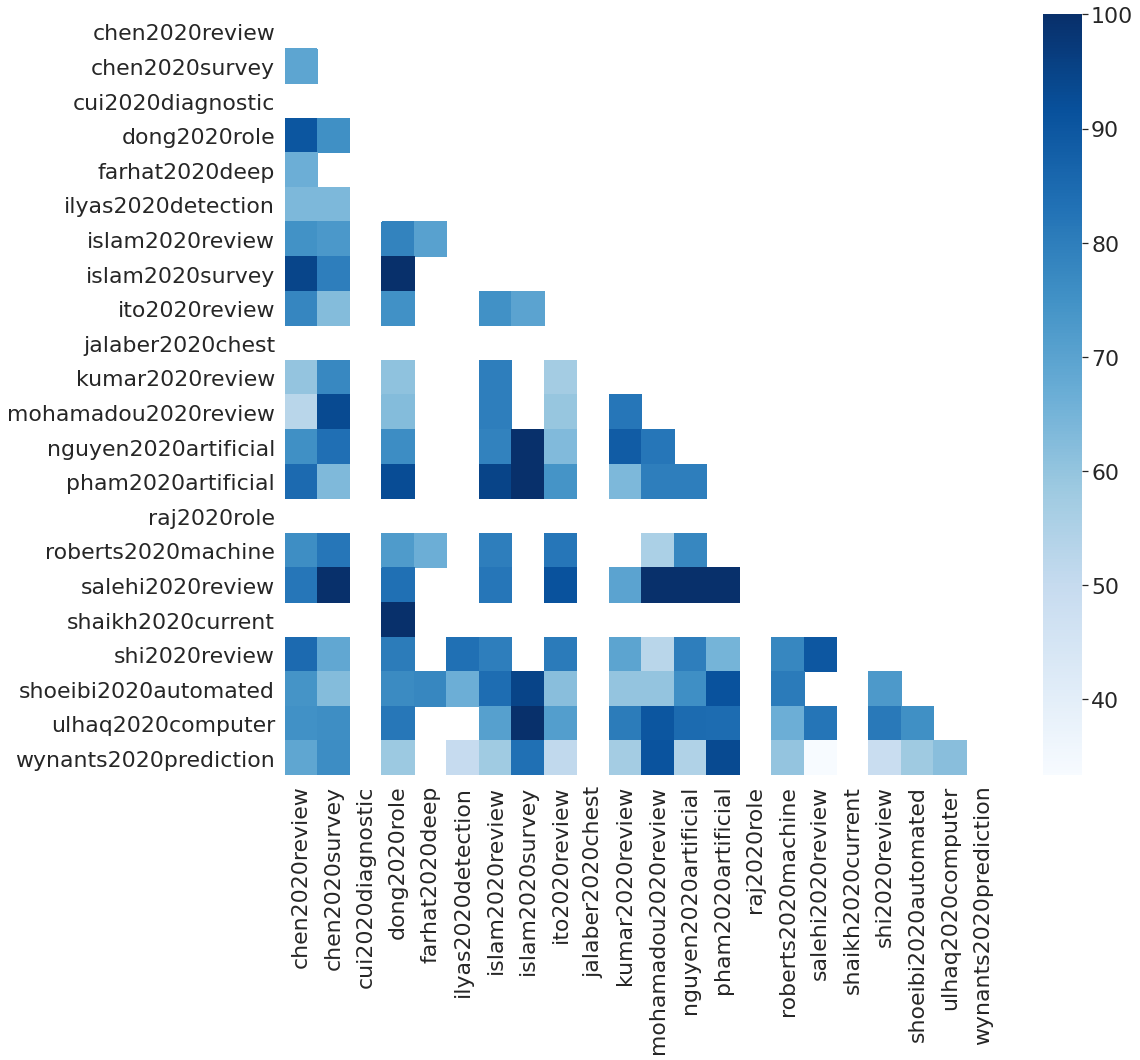

In [419]:
plt.figure(figsize=(16,14))
sns.heatmap(df_agreement_percent.transpose(), cmap='Blues')

plt.savefig(agreement_heatmap_name, format='eps', bbox_inches = 'tight')
plt.savefig(agreement_heatmap_name_png, format='png', bbox_inches = 'tight')

In [420]:
df_agreement_percent[df_agreement_percent >= 90].count()

chen2020review           0
chen2020survey           0
cui2020diagnostic        0
dong2020role             1
farhat2020deep           0
ilyas2020detection       0
islam2020review          0
islam2020survey          2
ito2020review            0
jalaber2020chest         0
kumar2020review          0
mohamadou2020review      1
nguyen2020artificial     1
pham2020artificial       3
raj2020role              0
roberts2020machine       0
salehi2020review         5
shaikh2020current        1
shi2020review            1
shoeibi2020automated     2
ulhaq2020computer        2
wynants2020prediction    2
dtype: int64

In [421]:
df_agreement_percent.mean()

chen2020review                  NaN
chen2020survey            69.318182
cui2020diagnostic               NaN
dong2020role              82.817816
farhat2020deep            66.666667
ilyas2020detection        63.636364
islam2020review           74.247710
islam2020survey           91.578947
ito2020review             72.114536
jalaber2020chest                NaN
kumar2020review           67.086355
mohamadou2020review       71.609682
nguyen2020artificial      81.021448
pham2020artificial        81.588022
raj2020role                     NaN
roberts2020machine        73.982323
salehi2020review          89.808227
shaikh2020current        100.000000
shi2020review             76.117113
shoeibi2020automated      74.261575
ulhaq2020computer         80.034630
wynants2020prediction     62.805271
dtype: float64

In [422]:
df_agreement_percent.describe()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
count,0.0,1.000000,0.0,2.000000,1.000000,2.000000,4.000000,3.000000,5.000000,0.0,5.000000,6.000000,8.000000,9.000000,0.0,8.000000,9.000000,1.0,12.000000,14.000000,14.000000,16.000000
mean,NaN,69.318182,NaN,82.817816,66.666667,63.636364,74.247710,91.578947,72.114536,NaN,67.086355,71.609682,81.021448,81.588022,NaN,73.982323,89.808227,100.0,76.117113,74.261575,80.034630,62.805271
std,NaN,NaN,NaN,10.388980,NaN,0.000000,3.500668,10.367219,6.008674,NaN,10.738612,15.744015,10.679332,13.091278,NaN,9.052646,11.066272,NaN,10.310121,11.245472,8.587185,16.100024
min,NaN,69.318182,NaN,75.471698,66.666667,63.636364,70.370370,80.000000,62.650602,NaN,57.142857,52.631579,63.265306,63.333333,NaN,55.555556,70.000000,100.0,52.631579,60.000000,66.666667,33.333333
25%,NaN,69.318182,NaN,79.144757,66.666667,63.636364,72.400285,87.368421,70.000000,NaN,60.000000,60.156250,76.002506,74.358974,NaN,70.833333,81.818182,100.0,69.436906,63.541667,75.077160,53.699789
50%,NaN,69.318182,NaN,82.817816,66.666667,63.636364,73.948533,94.736842,75.000000,NaN,60.869565,71.250000,80.492424,80.000000,NaN,76.888889,91.304348,100.0,80.000000,75.013163,80.947581,58.465819
75%,NaN,69.318182,NaN,86.490875,66.666667,63.636364,75.795959,97.368421,75.000000,NaN,77.419355,81.363636,84.933555,92.857143,NaN,80.454545,100.000000,100.0,81.449772,80.021368,83.997253,70.944816
max,NaN,69.318182,NaN,90.163934,66.666667,63.636364,78.723404,100.000000,77.922078,NaN,80.000000,93.333333,100.000000,100.000000,NaN,81.818182,100.000000,100.0,90.000000,95.000000,100.000000,93.333333


In [423]:
df_agreement_percent_full = (df_agreement_percent.transpose().fillna(0) + df_agreement_percent.fillna(0)).replace(0, np.nan)

In [424]:
df_agreement_percent_full.describe()

,chen2020review,chen2020survey,cui2020diagnostic,dong2020role,farhat2020deep,ilyas2020detection,islam2020review,islam2020survey,ito2020review,jalaber2020chest,kumar2020review,mohamadou2020review,nguyen2020artificial,pham2020artificial,raj2020role,roberts2020machine,salehi2020review,shaikh2020current,shi2020review,shoeibi2020automated,ulhaq2020computer,wynants2020prediction
count,17.000000,16.000000,0.0,16.000000,4.000000,5.000000,15.000000,9.000000,15.000000,0.0,13.000000,14.000000,15.000000,14.000000,0.0,12.000000,12.000000,1.0,15.000000,16.000000,15.000000,16.000000
mean,74.810110,75.426814,NaN,79.065262,70.370370,65.454545,77.408762,91.452242,70.201022,NaN,69.764826,74.349649,80.061084,83.467519,NaN,73.089355,84.479186,100.0,74.441908,73.317425,78.820200,62.805271
std,10.798759,10.843941,NaN,12.443870,5.237828,11.901416,8.052043,11.027812,10.836711,NaN,10.827355,16.618375,11.651861,12.941540,NaN,8.911565,18.798267,NaN,11.637533,11.230187,9.518152,16.100024
min,52.631579,62.500000,NaN,58.823529,66.666667,50.000000,58.000000,70.000000,51.162791,NaN,57.142857,52.631579,54.545455,63.333333,NaN,55.555556,33.333333,100.0,49.056604,58.108108,61.818182,33.333333
25%,69.230769,67.401628,NaN,74.305556,66.666667,63.636364,73.948533,83.333333,62.207654,NaN,60.000000,59.531250,75.933076,75.769231,NaN,66.666667,81.818182,100.0,69.176843,62.316176,73.214286,53.699789
50%,75.000000,75.639075,NaN,77.695035,68.518519,63.636364,79.166667,95.000000,71.428571,NaN,69.696970,80.000000,80.000000,84.860884,NaN,76.888889,86.666667,100.0,80.000000,74.829646,80.645161,58.465819
75%,81.818182,80.454545,NaN,85.040984,72.222222,66.666667,80.000000,100.000000,76.461039,NaN,80.000000,88.196481,84.233346,93.214286,NaN,80.192308,100.000000,100.0,81.035959,78.525641,83.379121,70.944816
max,94.736842,100.000000,NaN,100.000000,77.777778,83.333333,95.000000,100.000000,91.304348,NaN,88.571429,100.000000,100.000000,100.000000,NaN,81.818182,100.000000,100.0,90.000000,95.000000,100.000000,93.333333


In [425]:
df_agreement_percent_full.describe().transpose()['mean'].mean(), df_agreement_percent_full.describe().transpose()['mean'].std()

(76.77818695848072, 8.752212898635301)

In [426]:
df_agreement_percent_full[df_agreement_percent_full >= 90].count()

chen2020review           2
chen2020survey           2
cui2020diagnostic        0
dong2020role             4
farhat2020deep           0
ilyas2020detection       0
islam2020review          1
islam2020survey          6
ito2020review            1
jalaber2020chest         0
kumar2020review          0
mohamadou2020review      4
nguyen2020artificial     2
pham2020artificial       6
raj2020role              0
roberts2020machine       0
salehi2020review         6
shaikh2020current        1
shi2020review            1
shoeibi2020automated     2
ulhaq2020computer        2
wynants2020prediction    2
dtype: int64

In [427]:
# get list
# flatten it

values = [j for sub in df_agreement_percent.values.tolist() for j in sub]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

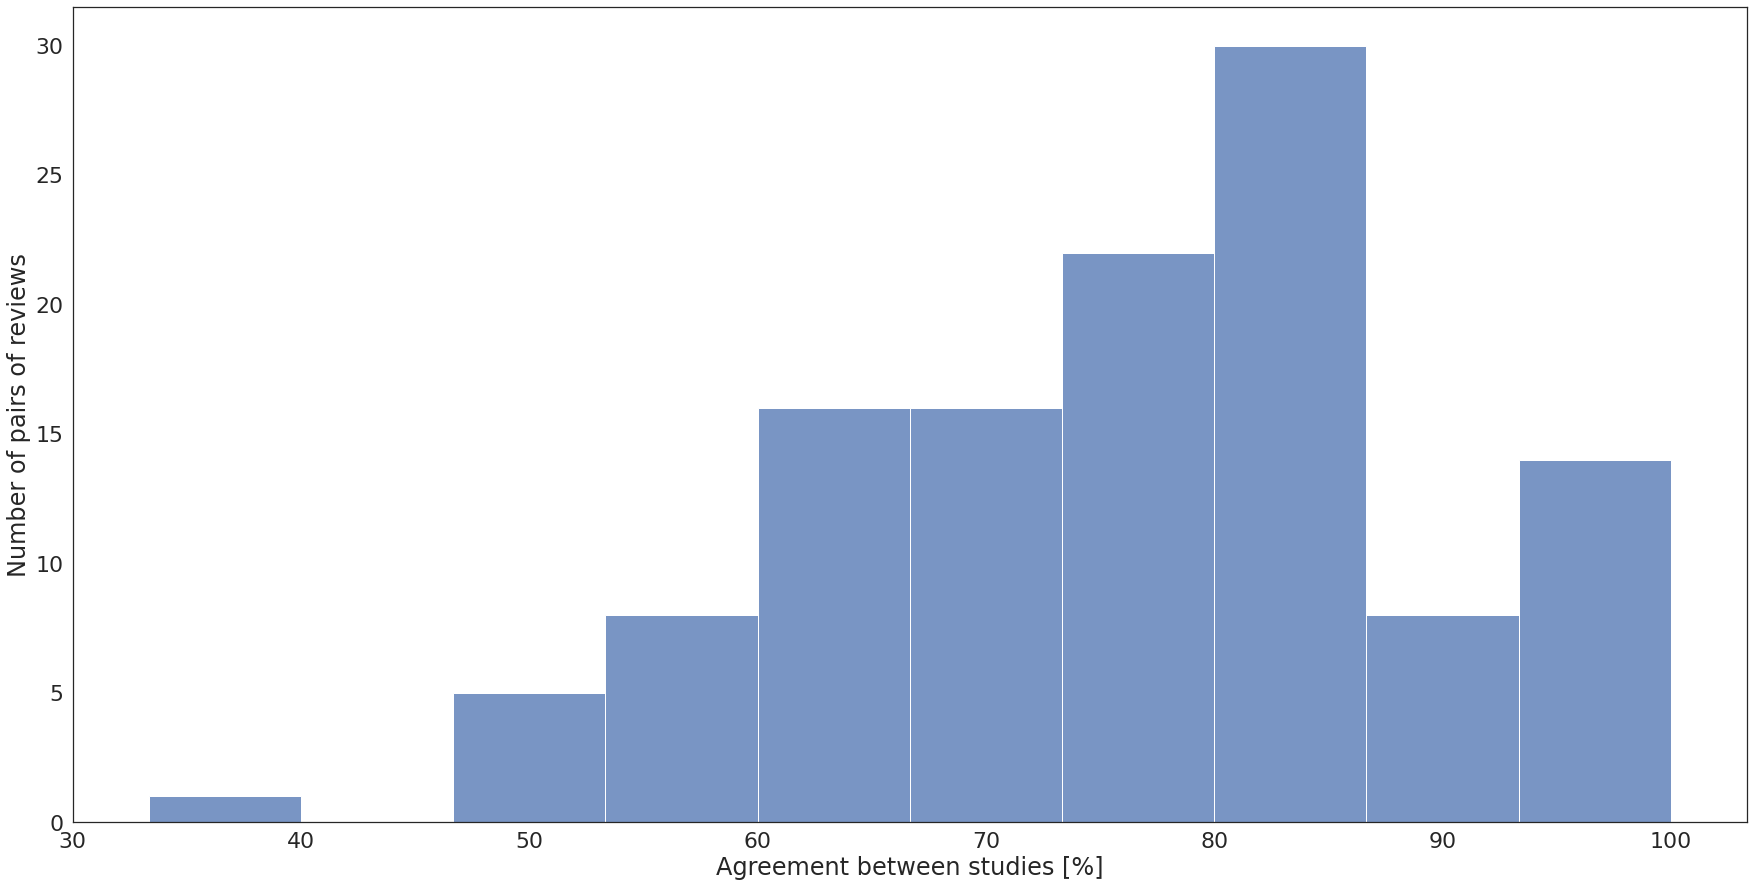

In [428]:
plt.figure(figsize=(30,15))
ax = sns.histplot(values)

ax.set(xlabel='Agreement between studies [%]', ylabel='Number of pairs of reviews')

plt.savefig(agreement_hist_name, format='eps', bbox_inches = 'tight')
plt.savefig(agreement_hist_name_png, format='png', bbox_inches = 'tight')